# Trabajo Practico N° 1
## Minería de datos

Año: 2025

Integrantes:
* Valentin Rosito
* Damián Grimaldi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering

import scipy.cluster.hierarchy as sch

In [2]:
cultivos = pd.read_csv('dxCrop_Soil.csv')
cultivos

,temperatura,humedad,aguaEnSuelo,tipoSuelo,tipoCultivo,nitrogeno,potasio,fosforo,nombreFertilizante
0,26.00,52.00,38.00,Arenoso,Maiz,37,0,0,Urea
1,29.00,52.00,45.00,Franco,CañaAzucar,12,0,36,DAP
2,34.00,65.00,62.00,Negro,Algodon,7,9,30,14-35-14
3,32.00,62.00,34.00,Rojo,Tabaco,22,0,20,28-28
4,28.00,54.00,46.00,Arcilloso,Arrozal,35,0,0,Urea
...,...,...,...,...,...,...,...,...,...
7995,35.30,59.61,44.25,Franco,SemillasOleaginosas,10,14,10,Urea
7996,39.39,71.67,49.34,Negro,Cebada,35,0,0,10-26-26
7997,35.79,67.64,45.04,Rojo,Cebada,41,0,0,Urea
7998,37.78,73.38,36.03,Negro,Tabaco,10,3,30,DAP


In [3]:
cultivos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperatura         8000 non-null   float64
 1   humedad             8000 non-null   float64
 2   aguaEnSuelo         8000 non-null   float64
 3   tipoSuelo           8000 non-null   object 
 4   tipoCultivo         8000 non-null   object 
 5   nitrogeno           8000 non-null   int64  
 6   potasio             8000 non-null   int64  
 7   fosforo             8000 non-null   int64  
 8   nombreFertilizante  8000 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 562.6+ KB


In [4]:
cultivos.isna().sum() # No hay valores nulos.

temperatura           0
humedad               0
aguaEnSuelo           0
tipoSuelo             0
tipoCultivo           0
nitrogeno             0
potasio               0
fosforo               0
nombreFertilizante    0
dtype: int64

In [5]:
cultivos.describe()

,temperatura,humedad,aguaEnSuelo,nitrogeno,potasio,fosforo
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,30.338895,59.210731,43.580862,18.429125,3.916375,18.512500
std,4.478262,8.177366,12.596156,11.852406,5.494807,13.244113
min,20.000000,40.020000,20.000000,0.000000,0.000000,0.000000
25%,27.050000,53.277500,33.967500,9.000000,0.000000,8.000000
50%,30.240000,59.110000,42.250000,14.000000,1.000000,18.000000
75%,33.460000,65.082500,52.950000,26.000000,5.000000,30.000000
max,40.000000,80.000000,70.000000,46.000000,23.000000,46.000000


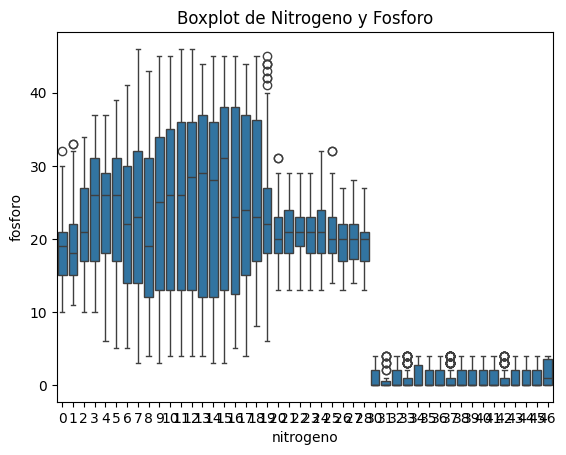

In [6]:
# Observamos que altos valores de nitrogeno estan vinculados a valores practicamente minimos de fosforo
sns.boxplot(data=cultivos, x = "nitrogeno", y = "fosforo")
plt.title('Boxplot de Nitrogeno y Fosforo')
plt.show()

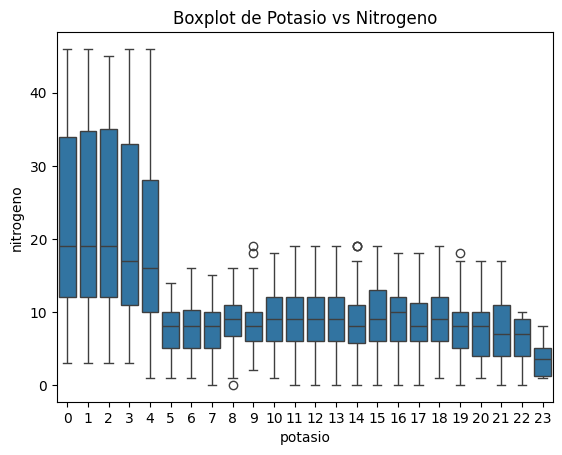

In [7]:
sns.boxplot(x="potasio", y = "nitrogeno", data=cultivos)
plt.title('Boxplot de Potasio vs Nitrogeno')
plt.show()

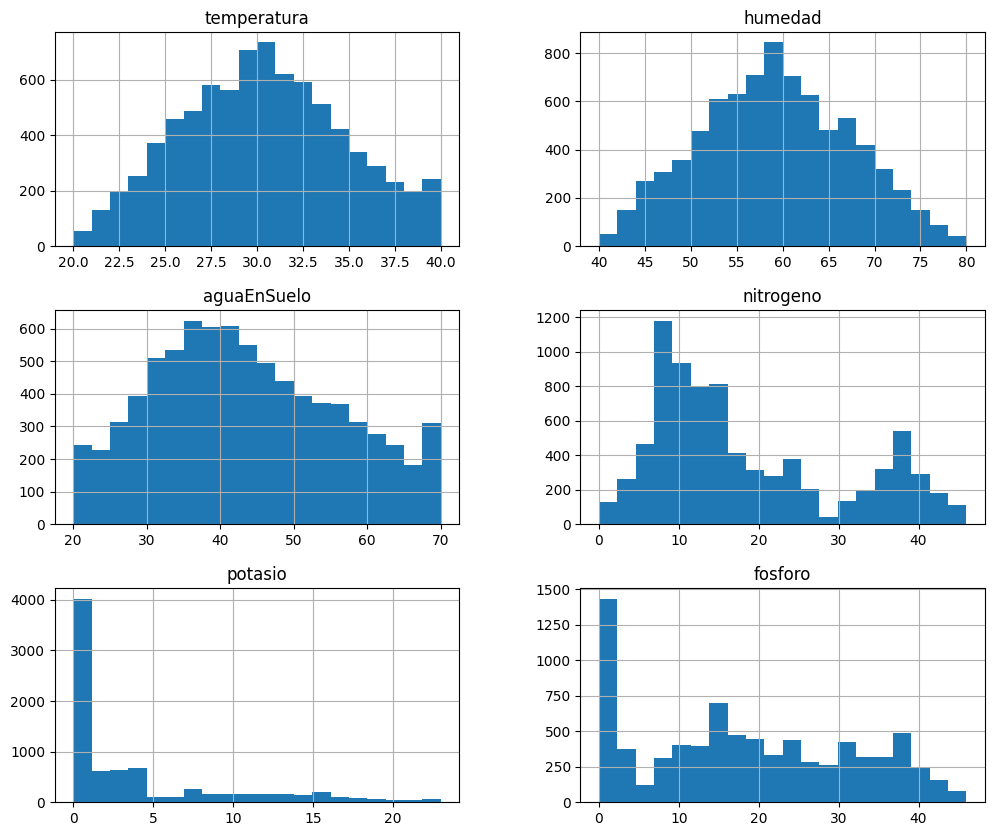

In [8]:
cultivos_sub = cultivos.drop(['nombreFertilizante','tipoCultivo','tipoSuelo'], axis=1)

cultivos_sub.hist(bins=20, figsize=(12, 10));

### Matriz de correlación

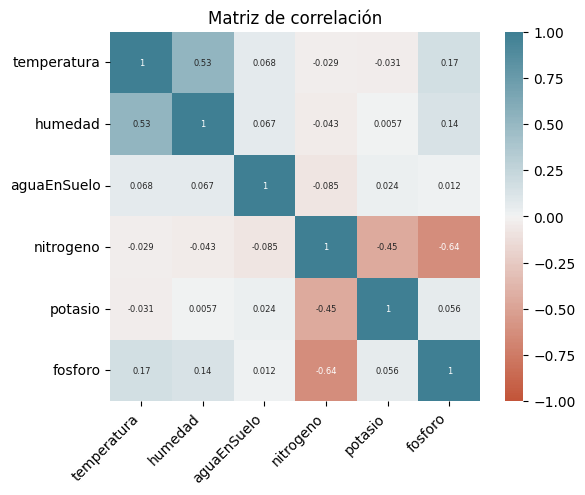

In [9]:
# Variables con mayor correlacion entre si: nitrógeno y potasio, fosforo con nitrógeno 
cultivos_sub = cultivos.drop(['nombreFertilizante','tipoCultivo','tipoSuelo'], axis=1)
corr = cultivos_sub.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Matriz de correlación')
plt.show()

## Ejercicio 2: Aplicar PCA 

In [10]:
# Dividimos el dataset entre la variable objetivo y las demas columnas
x = cultivos.drop(columns=['tipoCultivo'])
y = cultivos['tipoCultivo']

# Aplicamos One-hot encoding de todas las columnas categóricas
cultivos_ohe = pd.get_dummies(x, columns=['tipoSuelo', 'nombreFertilizante'])
nuevo = cultivos_ohe.drop(columns=['potasio'])

# Normalizamos las variables continuas con escalado estándar
scaler = StandardScaler()
columns_to_scale = ['temperatura', 'humedad', 'nitrogeno', 'fosforo', 'aguaEnSuelo']
scaled_values = scaler.fit_transform(nuevo[columns_to_scale])
cultivos_ohe_scaled = nuevo.copy()
cultivos_ohe_scaled[columns_to_scale] = scaled_values
X_scaled = cultivos_ohe_scaled

# Aplicamos PCA sobre el nuevo dataset
pca = PCA()
cultivos_pca = pca.fit_transform(X_scaled)

varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)
n_componentes = np.argmax(varianza_acumulada > 0.75) + 1
print(f"Con {n_componentes} componentes podemos explicar el 75% de la varianza.")


Con 5 componentes podemos explicar el 75% de la varianza.


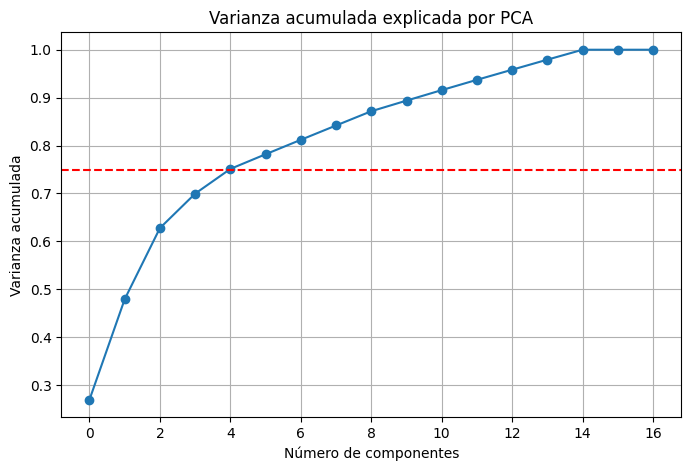

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(varianza_acumulada, marker='o')
plt.axhline(y=0.75, color='r', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza acumulada explicada por PCA')
plt.grid(True)
plt.show()

In [12]:
# Usamos los primeros 3 componentes para graficar
pca_df = pd.DataFrame(cultivos_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['tipoCultivo'] = cultivos['tipoCultivo'].values  # O del dataset original


fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='tipoCultivo',
    title='PCA - Primeras tres componentes principales',
    labels={'tipoCultivo': 'Tipo de Cultivo'}
)
fig.show()

# Ejercicio 3: Aplicar Isomap

In [ ]:
vecinos_list = [5, 15, 30, 50]
fig, axes = plt.subplots(len(vecinos_list), 1, figsize=(8, 12))

handles, labels = None, None

for idx, (n_neighbors, ax) in enumerate(zip(vecinos_list, axes)):
    isomap = Isomap(n_neighbors=n_neighbors, n_components=2)
    X_isomap = isomap.fit_transform(X_scaled)

    scatter = sns.scatterplot(
        x=X_isomap[:, 0],
        y=X_isomap[:, 1],
        hue=y,
        palette='viridis',
        legend=False,  
        ax=ax
    )
    if idx == 0:
        handles, labels = scatter.get_legend_handles_labels()

    ax.set_title(f'Isomap con n_neighbors = {n_neighbors}')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')

plt.tight_layout(rect=[0, 0, 0.8, 1])
fig.legend(handles, labels, loc='center right', title='tipoCultivo')
plt.show()


# Ejercicio 4: t-SNE

In [ ]:
interacciones = [1000, 2000, 3000, 4000, 5000]
perplejidades = [5, 10, 30, 50, 100, 200, 300]
componentes = [2,3]

componente = 2
perplejidad = 50
interaccion = 2000

tsne = TSNE(n_components=componente, perplexity=perplejidad, max_iter=interaccion, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(tsne_result, columns=[f'TSNE_{i+1}' for i in range(componente)])
tsne_df['tipoCultivo'] = cultivos['tipoCultivo'].values
fig = px.scatter(
    tsne_df,
    x='TSNE_1',
    y='TSNE_2',
    color='tipoCultivo',
    title=f'T-SNE 2D - Perplejidad={perplejidad}, Iteraciones={interaccion}',
    labels={'tipoCultivo': 'Tipo de Cultivo'}
)
fig.show()

'''
- Al aumentar la perplejidad, se observa que los puntos se agrupan más, 
lo que indica que el modelo está capturando mejor la estructura de los datos.

- Al aumentar el número de iteraciones, los puntos tienden a
  agruparse más.

- Al aumentar el número de componentes, se observa que los puntos tienden a
  separarse más
'''


KeyboardInterrupt: 

In [ ]:
# Filtramos los datos para incluir solo los tipos de cultivo
cultivos_filtrados = cultivos[cultivos['tipoCultivo'].isin(['Maiz', 'Cebada', 'Trigo'])]
X_filtrado = pd.get_dummies(cultivos_filtrados.drop(columns=['tipoCultivo']))

# Eliminamos la columna 'potasio'
X_filtrado = X_filtrado.drop(columns=['potasio'])

# Identificamos las columnas numéricas a escalar (todas excepto las dummies)
cols_to_scale = ['temperatura', 'humedad', 'nitrogeno', 'fosforo', 'aguaEnSuelo']
# Usamos el mismo scaler ya entrenado para mantener la coherencia
X_filtrado_scaled = X_filtrado.copy()

X_filtrado_scaled[cols_to_scale] = scaler.transform(X_filtrado[cols_to_scale])

# Ejercicio 5: Apliar PCA nuevamente al subdataset 2D

In [ ]:
# Nos aseguramos mismas columnas y orden que el PCA original
X_filtrado_scaled = X_filtrado.reindex(columns=X_scaled.columns, fill_value=0)

# Transformamos con el PCA ya entrenado
X_filtrado_pca = pca.transform(X_filtrado_scaled)

# Visualizamos las primeras 3 componentes principales
pca_filtrado_df = pd.DataFrame(X_filtrado_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_filtrado_df['tipoCultivo'] = cultivos_filtrados['tipoCultivo'].values

fig = px.scatter(
    pca_filtrado_df,
    x='PC1',
    y='PC2',
    color='tipoCultivo',
    title='PCA (Maiz, Cebada, Trigo) - Primeras 3 componentes',
    labels={'tipoCultivo': 'Tipo de Cultivo'}
)
fig.show()

## Ejercicio N°6: Aplicar K-means y analizar los resultados obtenidos variando el número de clusters y obtener el número óptimo de clusters mediante GAP

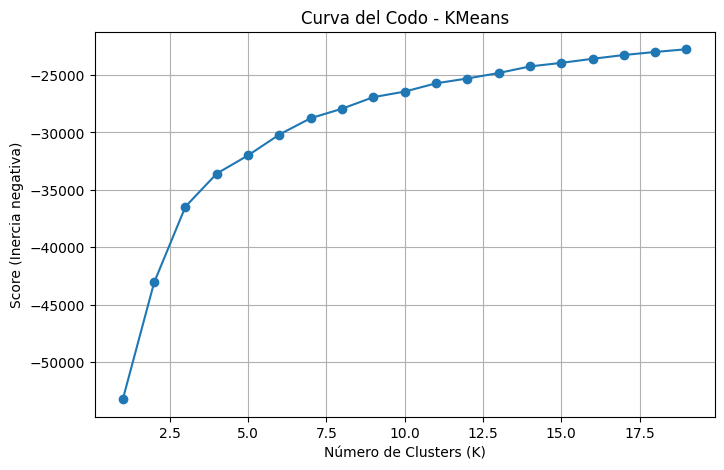

In [ ]:
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i, random_state=42) for i in Nc]
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.figure(figsize=(8, 5))
plt.plot(Nc, score, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Score (Inercia negativa)')
plt.title('Curva del Codo - KMeans')
plt.grid(True)
plt.show()

In [ ]:
def gap_statistic(X, n_refs=20, max_clusters=20) -> int:
    shape = X.shape
    tops = X.max(axis=0)
    bottoms = X.min(axis=0)
    
    dists = [np.random.uniform(bottoms, tops, size=shape) for _ in range(n_refs)]
    gaps = []

    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state = 42).fit(X)
        disp = np.sum(np.min(pairwise_distances(X, kmeans.cluster_centers_), axis=1))
        
        ref_disps = []
        for ref in dists:
            km = KMeans(n_clusters=k, random_state = 42).fit(ref)
            ref_disp = np.sum(np.min(pairwise_distances(ref, km.cluster_centers_), axis=1))
            ref_disps.append(ref_disp)

        gap = np.log(np.mean(ref_disps)) - np.log(disp)
        gaps.append(gap)

    optimal_k = np.argmax(gaps) + 1

    return optimal_k

optima_k = gap_statistic(X_scaled)

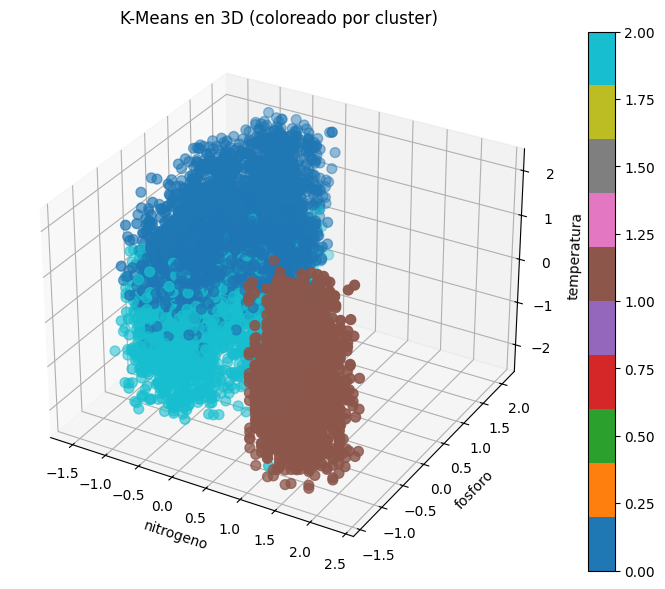

In [ ]:
X_3d = X_scaled[['nitrogeno','fosforo','temperatura']]
kmeans = KMeans(n_clusters=optima_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)  # Asignamos los clusters

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_3d['nitrogeno'], X_3d['fosforo'], X_3d['temperatura'], c=labels, cmap='tab10', s=50)
ax.set_xlabel('nitrogeno')
ax.set_ylabel('fosforo')
ax.set_zlabel('temperatura')
ax.set_title('K-Means en 3D (coloreado por cluster)')
plt.colorbar(scatter)
plt.show()

## Ejercicio N°7: Aplicar clustering jerárquico y determinar cuál número sería el que mejor represente los datos.

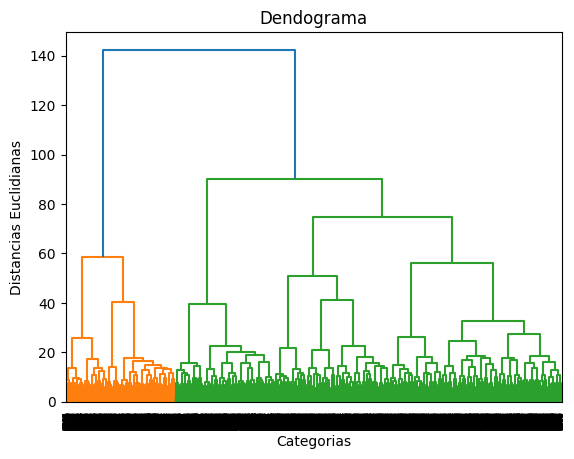

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method = 'ward'))
plt.title('Dendograma')
plt.xlabel('Categorias')
plt.ylabel('Distancias Euclidianas')
plt.show()

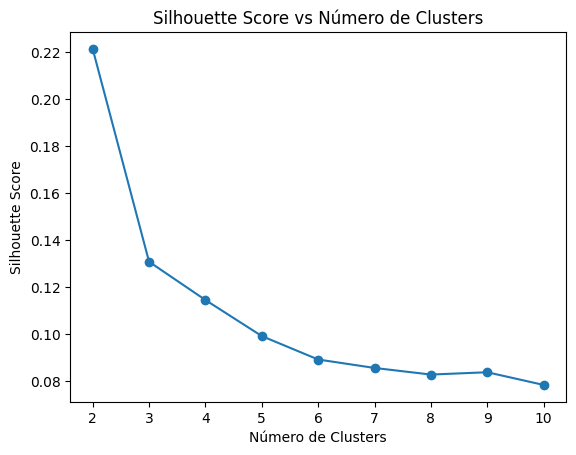

In [ ]:
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    cluster = AgglomerativeClustering(n_clusters=k)
    labels = cluster.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.plot(k_range, sil_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Número de Clusters')
plt.show()

k_silhouette = k_range[np.argmax(sil_scores)]

In [ ]:
def calculate_inertia(X, labels):
    inertia = 0
    for label in np.unique(labels):
        cluster_points = X[labels == label]
        cluster_center = cluster_points.mean(axis=0)
        inertia += np.sum((cluster_points - cluster_center) ** 2)
    return inertia

def gap_statistic(X, n_refs=10, max_k=10):
    gap_values = []
    for k in range(1, max_k+1):
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X)
        inertia_original = calculate_inertia(X, labels)
        
        reference_inertia = 0
        for _ in range(n_refs):
            X_random = np.random.permutation(X)  # Datos aleatorios
            labels_random = model.fit_predict(X_random)
            reference_inertia += calculate_inertia(X_random, labels_random)
        
        gap_value = np.log(reference_inertia / n_refs) - np.log(inertia_original)
        gap_values.append(gap_value)
        
        optimal_k = np.argmax(gap_values) + 1
    
    return optimal_k

optimal_k = gap_statistic(X_scaled, n_refs=10, max_k=10)

In [ ]:
print(f"El número óptimo de clusters según el método de gap es: {optimal_k}")
print(f"Número óptimo de clusters según Silhouette: {k_silhouette}")

El número óptimo de clusters según el método del codo es: 14
Número óptimo de clusters según Silhouette: 2


### Conclusiones

En este trabajo, se realizó un análisis exploratorio y de reducción de dimensionalidad sobre el conjunto de datos dxCrop_Soil.csv, centrado en la variable objetivo tipoCultivo. Durante el análisis exploratorio inicial se identificaron los datos faltantes, pero estos se podian explicarse a traves de Nitrogeno, por lo que no se modifico.

Aplicamos tecnicas de reduccion de dimensionalidad, en las cuales, no tomamos en cuenta la columna de potasio, ya que. Estas tecnicas, nos permitieron observar como se distribuian las variables, tanto en 2d o en 3d, dependiendo del modelo.

Posteriormente, implementamos métodos de clustering como K-Means y clustering jerárquico. Se utilizó el Gap Statistic y el Silhouette Score para determinar el número óptimo de clusters. Se identifico que para K-Means, el numero optimo es 3, y en Jerárquico, se obtuvo 2 con Silhouette, el mejor resultado en comparacion con el metodo de gap static

En conclusión, este trabajo permitió aplicar y comparar distintas técnicas de reducción de dimensionalidad y agrupamiento, profundizando en el análisis del tipo de cultivo a partir de variables de suelo. Los métodos visuales y estadísticos aplicados ofrecieron información valiosa sobre la estructura latente del dataset y su potencial de segmentación y clasificación.